#Import library

In [1]:
!pip install nltk

In [2]:
import glob
import os
import numpy as np

#Import NLTK
#The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and statistical natural language processing for English written in the Python programming language


In [3]:
import nltk

#Import corpus of names
from nltk.corpus import names
nltk.download('names')

#WordNet is just another NLTK corpus reader. Here it is used for word lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#the dataset of spam is imported on gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Dataset

In [5]:
emails, labels = [], []
#Importing the spam files
file_path = '/content/drive/MyDrive/myspam'
for filename in glob.glob(os.path.join(file_path, '*.txt')): #Loop until no more file
    with open(filename, 'r', encoding = "ISO-8859-1") as infile:
        emails.append(infile.read()) #Read files
        labels.append(1) # Declare spams labels as 1

#Importing the ham Files
file_path = '/content/drive/MyDrive/myham' 
for filename in glob.glob(os.path.join(file_path, '*.txt')): #Loop until no more file
    with open(filename, 'r', encoding = "ISO-8859-1") as infile:
        emails.append(infile.read()) #Read files
        labels.append(0) # Declare ham labels as 0

#Dataset Preprocessing

In [6]:
#Removing stop word using sklearn.feature)extraction.text to improve the model.
#By reducing stop words , will lessen the learn set and improve the quality as stop words doesn't contribute more

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english", max_features=500)

In [7]:
#Delete everything that is not letters
def letters_only(astr):
    return astr.isalpha()

#set names
all_names = set(names.words())

#Declare lemmatizer
#Lemmatisation is to reduce words to a base form
lemmatizer = WordNetLemmatizer()

#Clean the text from names and other than words
def clean_text(docs):
    cleaned_docs = []
    for doc in docs:
        cleaned_docs.append(' '.join([lemmatizer.lemmatize(word.lower()) for word in doc.split() if letters_only(word) and word not in all_names]))
    return cleaned_docs

#Clean text
cleaned_emails = clean_text(emails)
term_docs = cv.fit_transform(cleaned_emails)

In [8]:
#Spliting Dataset with 20% test size
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_emails, labels, test_size=0.25, random_state=42)

#Making the model


In [9]:
term_docs_train = cv.fit_transform(X_train)
term_docs_test = cv.transform(X_test)

In [10]:
#Building the model using sklearn.naive_bayes
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=1.0, fit_prior=True)
model.fit(term_docs_train, Y_train)
prediction_prob = model.predict_proba(term_docs_test)
prediction_prob[0:10]
prediction = model.predict(term_docs_test)
prediction[:10]
accuracy = model.score(term_docs_test, Y_test)

#Print the
print('The accuracy of the model is: {0:.1f}%'.format(accuracy*100))

The accuracy of the model is: 100.0%


#Model Evaluation

In [11]:
#Evaluate the model on confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[17  0]
 [ 0 15]]


No handles with labels found to put in legend.


1.0


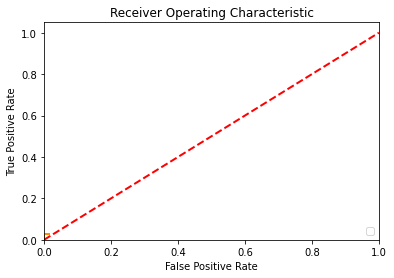

In [12]:
#Evaluate the model on ROC Curve and score
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else:
                false_pos[i] += 1
        else:
            break

true_pos_rate = [tp / 516.0 for tp in true_pos]
false_pos_rate = [fp / 1191.0 for fp in false_pos]

from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y_test, pos_prob))

import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()